In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Template 02
- multi-class - Fashion MNIST dataset (all 60000 images)

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns

In [3]:
import tensorflow as tf

2024-05-28 12:51:42.445180: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 12:51:42.497252: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 12:51:42.497290: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 12:51:42.498472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 12:51:42.505997: I tensorflow/core/platform/cpu_feature_guar

In [4]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [5]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid(True);
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid(True);
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [34]:
# Some basic parameters
inpDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 12/input' # location where input data is stored
outDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 12/output' # location to store outputs
# subDir = 'fashion_MNIST' # location of the images
modelDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 12/models'
logDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 12/logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)
EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

REG_LAMBDA = 0.005
PATIENCE = 20 # EarlyStopping -> If n no. of epochs give similar o/p, then it will stop the execution
LR_PATIENCE = 10
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygine Check

In [7]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir)):
    os.makedirs(os.path.join(modelDir))
    print ('Created {} directory'.format(os.path.join(modelDir)))

if not os.path.exists(os.path.join(logDir)):
    os.makedirs(os.path.join(logDir))
    print ('Created {} directory'.format(os.path.join(logDir)))

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [8]:
train_filename = os.path.join(inpDir, 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [9]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',
               1:'Trouser',
               2:'Pullover',
               3:'Dress',
               4:'Coat',
               5:'Sandal', 
               6: 'Shirt',
               7: 'Sneaker', 
               8:'Bag', 
               9: 'Ankle boot'}

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [10]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

Each label is an integer between 0 and 9:

In [12]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

In [13]:
def split_features_label(row):
    feature = tf.reshape(row[1:],[28,28,1])
    label = row[0]
    # print(feature, label)
    return feature, label

In [14]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(split_features_label)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds

2024-05-28 12:51:49.174587: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(split_features_label)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Whats in the data?

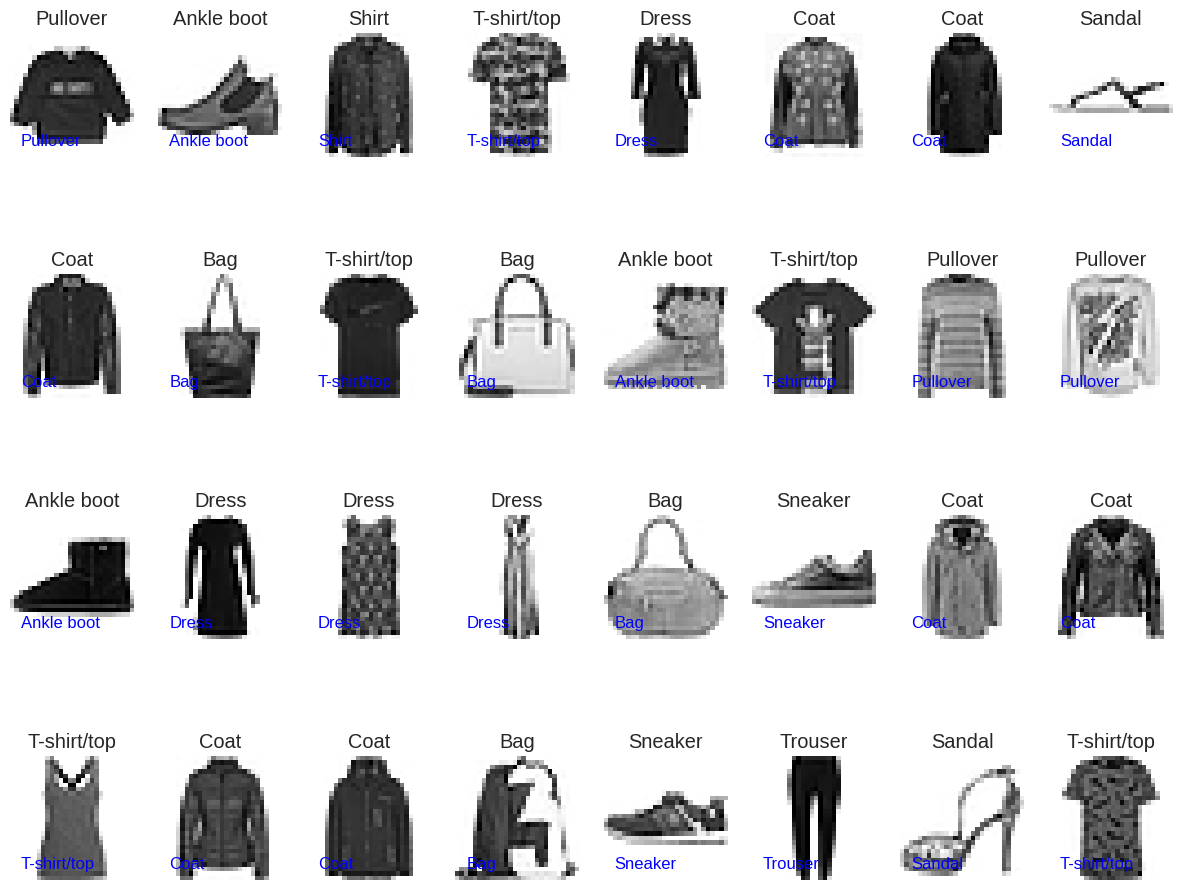

In [16]:
# Sample data plot

fig = plt.figure(figsize=(15, 12))  # figure size in inches

for images , labels in train_ds.take(1): # iterate through all rows of the dataframe
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)
        plt.imshow(images[i], cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image
        plt.text(2, 25, class_names[labels[i].numpy()], color='b', fontsize=12)   # add name of the image
        plt.axis('off')
    
plt.show()

## Optimizing for performance - Cache

In [17]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## In subsequent copies, delete these lines

In [18]:
norm_layer = tf.keras.layers.Rescaling(1./255.) # Rescaling Layer
images, labels = next(iter(train_ds))   # One Batch
img = images[0].numpy()

print(img.max(), img.min())

################################################################################################################

norm_ds = train_ds.map(lambda x,y: (norm_layer(x),y))
images, labels = next(iter(norm_ds))    # One Batch
img = images[0].numpy()

print(img.max(), img.min())


255 0
1.0 0.0


2024-05-28 12:51:51.437073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-28 12:51:51.544433: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Convolution Layer

In [19]:
input_shape = (1,6,6,1) # batch * h * w * c
X = tf.random.normal(input_shape)

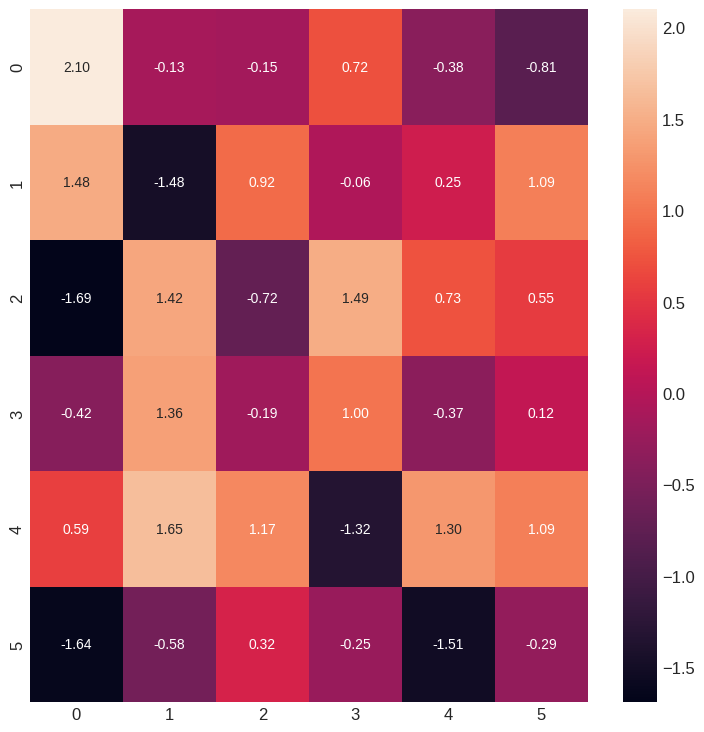

In [20]:
sns.heatmap(X.numpy()[0, :, :, 0], annot=True, fmt='.2f');

In [21]:
y = tf.keras.layers.Conv2D(1,3, 
                           kernel_initializer = tf.constant_initializer(1.),
                           use_bias = False, 
                           activation = 'relu', 
                           input_shape = input_shape[1:])(X)

y.shape

TensorShape([1, 4, 4, 1])

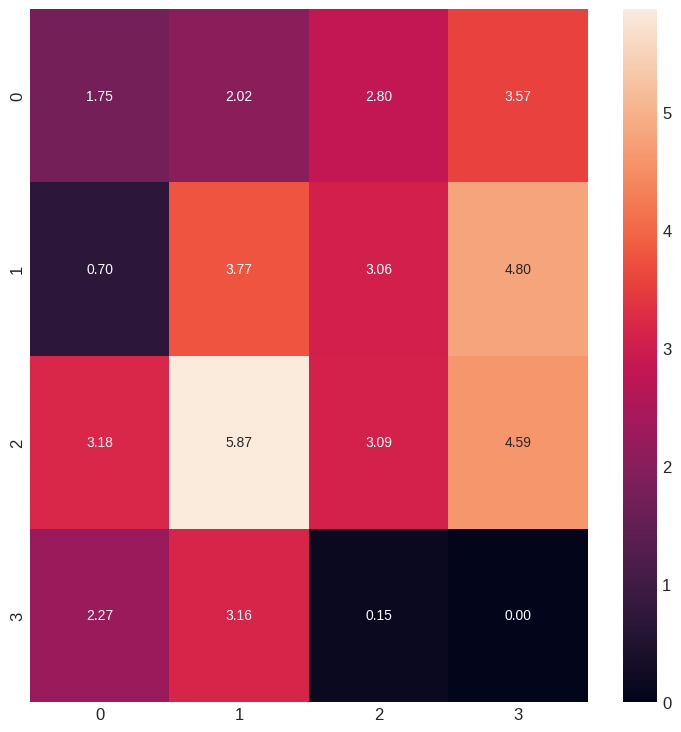

In [22]:
sns.heatmap(y.numpy()[0, :, :, 0], annot=True, fmt='.2f');

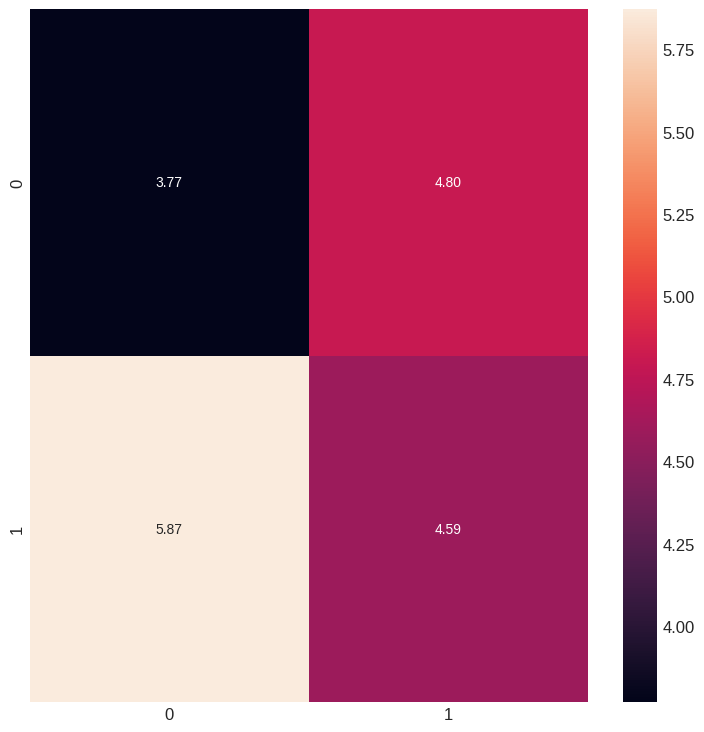

In [23]:
max_pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')

Z = max_pool_layer(y)

sns.heatmap(Z.numpy()[0, :, :, 0], annot=True, fmt='.2f');

tf.keras.layers.conv2D:

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

tf.keras.layers.MaxPooling2D:

https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2

In [24]:
# tf.keras.layers.Conv2D(
#     filters,
#     kernel_size,
#     strides=(1, 1),
#     padding='valid',
#     data_format=None,
#     dilation_rate=(1, 1),
#     groups=1,
#     activation=None,
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     bias_initializer='zeros',
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     **kwargs
# )


In [25]:
# tf.keras.layers.MaxPool2D(
#     pool_size=(2, 2),
#     strides=None,
#     padding='valid',
#     data_format=None,
#     name=None,
#     **kwargs
# )

# Convolutional Layers

In [35]:
k_reg = tf.keras.regularizers.L2(REG_LAMBDA)

model = tf.keras.Sequential()

# Pre-processing
model.add(tf.keras.layers.Rescaling(1./255.))

##############################################################
# Convolutional Layers
##############################################################

############################## Set 1 ##############################
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape = [28, 28, 1])) 
# Expected output: 28x28x32
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Expected output; 14x14x32

############################## Set 2 ##############################
model.add(tf.keras.layers.Conv2D(64, 3, activation='relu')) 
# Expected output: 12x12x64
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Expected output; 6x6x64

############################## Set 3 ##############################
model.add(tf.keras.layers.Conv2D(128, 3, activation='relu')) 
# Expected output: 4x4x128

## Head

In [36]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer = k_reg))
model.add(tf.keras.layers.Dense(10))

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [38]:
chechpoint_path=os.path.join(modelDir, '')


model_checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(
    chechpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
#   save_freq='epoch',
#   initial_value_threshold=None
)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    # min_delta=0,
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    # baseline=None,
    restore_best_weights=True
    # start_from_epoch=0
)

learning_rate_callback  = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    #min_delta=0.0001,
    #cooldown=0,
    min_lr=0.00001,
    # **kwargs
)

log_dir = os.path.join(logDir, 'fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [39]:
history = model.fit( train_ds,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [model_checkpoint_callback, 
                                 early_stopping_callback, 
                                 learning_rate_callback],
                    validation_data = test_ds)

Epoch 1/10


1873/1875 [============================>.] - ETA: 0s - loss: 0.5547 - accuracy: 0.8317
Epoch 1: val_loss improved from inf to 0.40233, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 12/models/
1875/1875 [==============================] - 29s 15ms/step - loss: 0.5545 - accuracy: 0.8318 - val_loss: 0.4023 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.8863
Epoch 2: val_loss improved from 0.40233 to 0.36907, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 12/models/
1875/1875 [==============================] - 28s 15ms/step - loss: 0.3705 - accuracy: 0.8863 - val_loss: 0.3691 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.9005
Epoch 3: val_loss improved from 0.36907 to 0.33937, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/Lecture/Day 12/mode

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

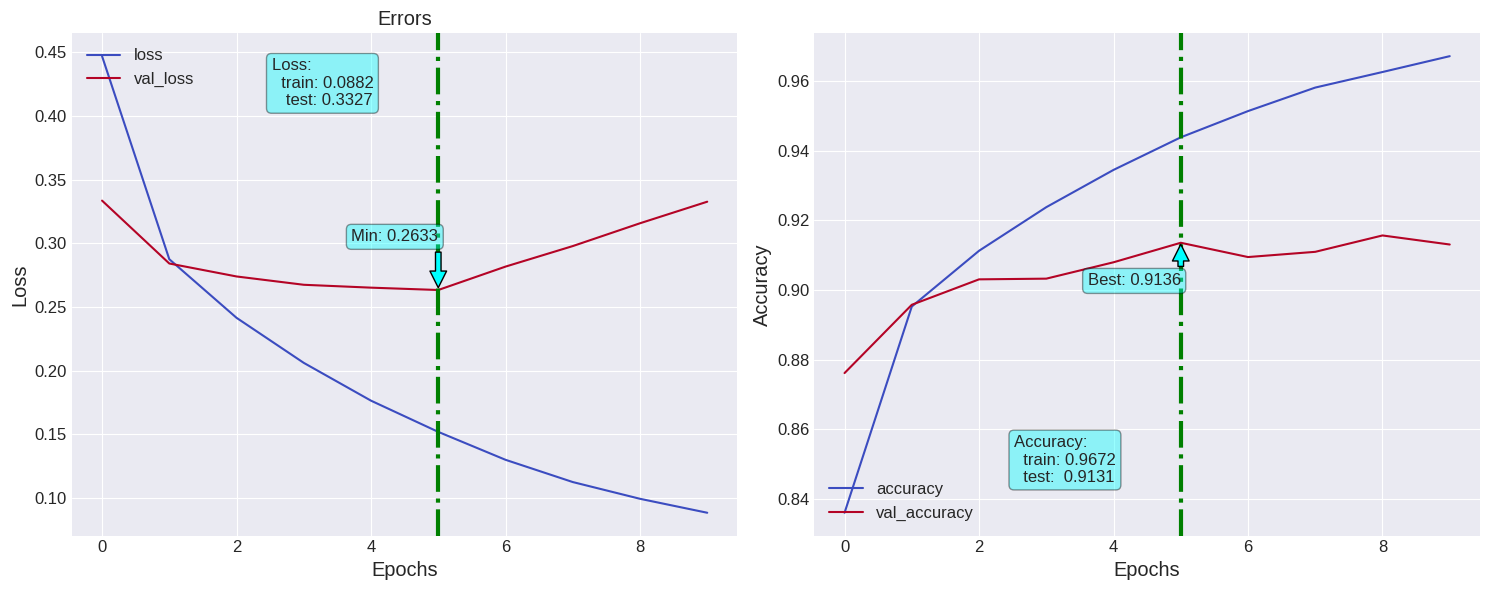

In [33]:
fn_plot_tf_hist(pd.DataFrame(history.history))